# Resolução da DFT e adição de zeros

Neste notebook avaliaremos aspectos de resolução da DFT e da adição de zeros (zero padding).

Notamos que um sinal com $N$ amostras, amostrado a uma taxa $F_s$ {Hz] possuirá um vetor de frequências

\begin{equation}
f_{Hz}^{(k)} = \left\{\frac{0F_{s}}{N}, \ \frac{1F_{s}}{N}, \  \frac{2F_{s}}{N}, \ ... \ \frac{(N-1)F_{s}}{N}\right\}
\end{equation}

In [1]:
# importar as bibliotecas necessárias
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 14})
import IPython.display as ipd # to play signals
import sounddevice as sd
import soundfile as sf

In [4]:
Fs = 20
T = 0.95

time_vec = np.arange(0, T+1/Fs, 1/Fs)
N = len(time_vec)

freq_vec = np.linspace(0, (N-1)*Fs/N, N)

print("Time: {} [s]".format(np.around(time_vec, decimals=10)))
print("Freq: {} [Hz]".format(np.around(freq_vec, decimals=10)))

Time: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95] [s]
Freq: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.] [Hz]


In [5]:
N

20

## Vamos criar uma resposta ao impulso ideal

Esta é a resposta ao impulso de um sistema massa-mola (1DOF)

\begin{equation}
h(t) = \frac{A}{\omega_d} \mathrm{e}^{-\zeta \omega_n t} \mathrm{sin}(\omega_d t)
\end{equation}
com $\zeta$ sendo o amortecimento, $\omega_n = 2 \pi f_1$ e $\omega_d = \omega_n\sqrt{1-\zeta^2}$, que possui TF, dada por

\begin{equation}
H(\mathrm{j}\omega) = \frac{A}{\omega_n^2 - \omega^2+ \mathrm{j}2\zeta\omega_n\omega} 
\end{equation}

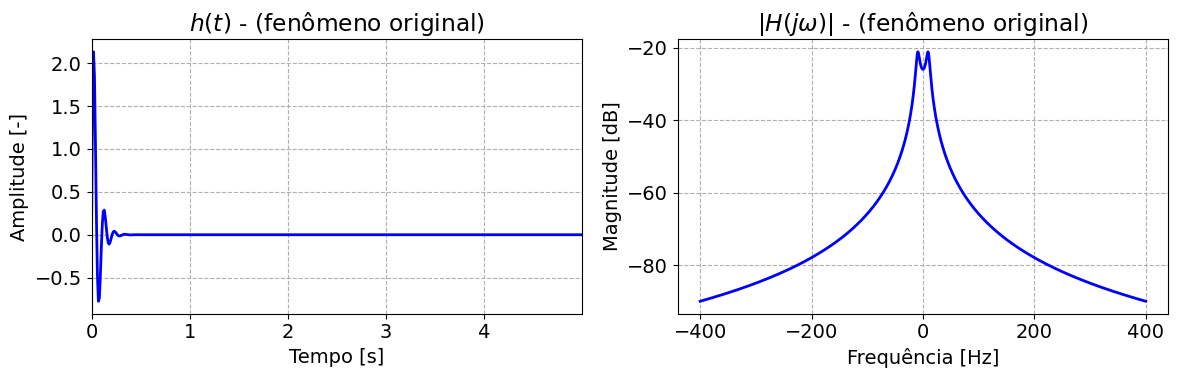

In [14]:
# Define the sampling rate fs = 100 Hz and total record time T = 5 seconds
Fs=100
T=5 
# time vector
time = np.arange(0, T, 1/Fs) # Ts = 0.01 [s]

# Sinal puro (Fenômeno) - original - h(t) de um S1GL (massa-mola)
A=200
zeta=0.3
wn=2*np.pi*10
wd=np.sqrt(1-zeta**2)*wn
# Impulse response
ht=(A/wd)*np.exp(-zeta*wn*time)*np.sin(wd*time)
# FRF teorica
freq = np.arange(-4*Fs, 4*Fs, 0.01)

Hw=A/(wn**2 - (2*np.pi*freq)**2+ 1j*2*zeta*wn*(2*np.pi*freq));


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title(r'$h(t)$ - (fenômeno original)')
plt.plot(time, ht, '-b', linewidth = 2)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((0, time[-1]))

plt.subplot(1,2,2)
plt.title(r'$|H(j\omega)|$ - (fenômeno original)')
plt.plot(freq, 20*np.log10(np.abs(Hw)), '-b', linewidth = 2)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
#plt.xlim((-Fs, Fs))
#plt.ylim((-80, -20))
plt.tight_layout()
plt.show()

## Adicionamos ruído a resposta ao impulso (fenômeno ideal)

Tipicamente, é isso que acontece em uma medição. Ela sempre estará contaminada por ruído em algum grau. O ruído vai ter característica de ruído branco (distribuição normal com média zero e uma variância).

In [20]:
noise = np.random.normal(loc = 0, scale = 0.01, size = len(time))
ht_med = ht+noise

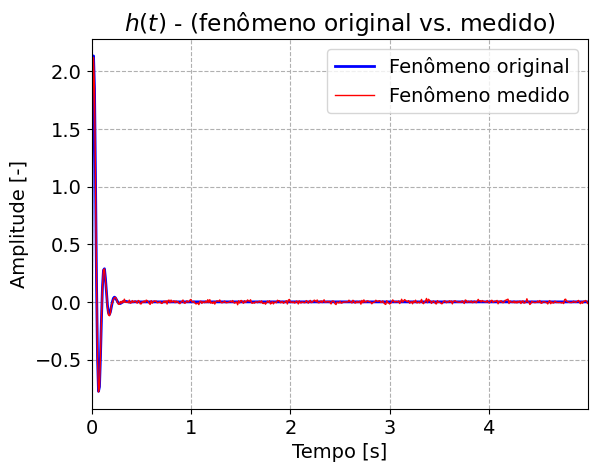

In [21]:
plt.figure()
plt.title(r'$h(t)$ - (fenômeno original vs. medido)')
plt.plot(time, ht, '-b', linewidth = 2, label = 'Fenômeno original')
plt.plot(time, ht_med, '-r', linewidth = 1, label = 'Fenômeno medido')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((0, time[-1]));

## Agora podemos investigar a FFT e sua resolução para alguns casos

### 1. Resolução original

"If n is not given, the length of the input along the axis specified by axis is used."

Se n não for dado, to comprimento da entrada (ao longo do eixo especificado) é usado - Em outras palavras, o espectro tem o mesmo número de pontos que o sinal no domínio do tempo.

Vetor de frequência: 0.00, 0.20, 0.40, ... 99.80
Resolução do espectro: 0.20 [Hz]


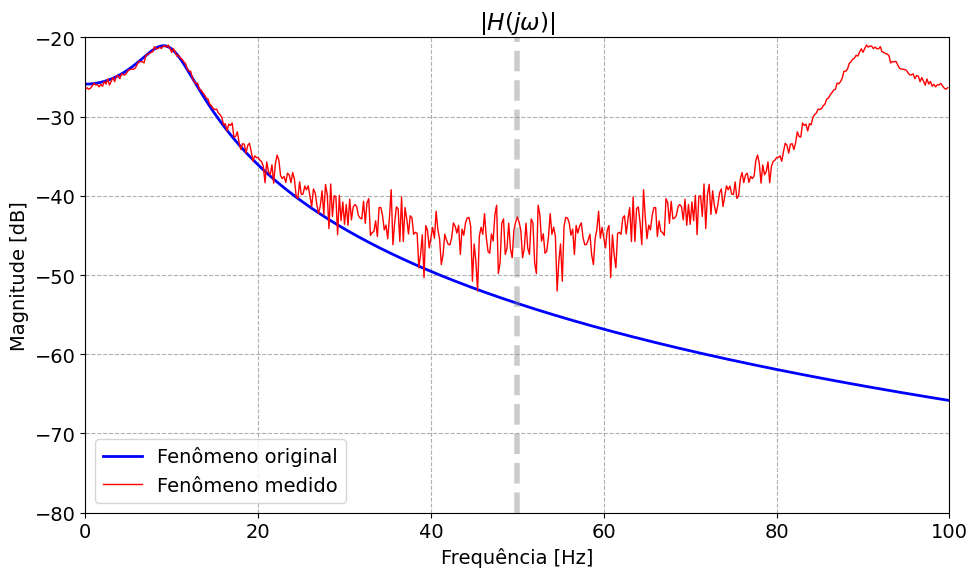

In [22]:
N = len(ht_med) # Número de pontos da FFT
Hw_med = np.fft.fft(ht_med)
freq_vec = np.linspace(0, (N-1)*Fs/N, N)
print("Vetor de frequência: {:.2f}, {:.2f}, {:.2f}, ... {:.2f}".format(freq_vec[0], freq_vec[1], freq_vec[2], freq_vec[-1]))
print("Resolução do espectro: {:.2f} [Hz]".format(freq_vec[1]-freq_vec[0]))


plt.figure(figsize=(10,6))
plt.title(r'$|H(j\omega)|$')
plt.plot(freq, 20*np.log10(np.abs(Hw)), '-b', linewidth = 2, label = 'Fenômeno original')
plt.plot(freq_vec, 20*np.log10(np.abs(Hw_med)/Fs), '-r', linewidth = 1, label = 'Fenômeno medido')
plt.legend(loc = 'lower left')
plt.axvline(Fs/2, color='grey',linestyle = '--', linewidth = 4, alpha = 0.4)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.xlim((0, Fs))
plt.ylim((-80, -20))
plt.tight_layout()
#plt.savefig('dft_mag_par.pdf')
plt.show()

In [16]:
N

500

In [23]:
print(Hw_med[150])
print(Hw_med[350])

(-0.6605070467539891-0.018173356709065835j)
(-0.6605070467539887+0.018173356709064947j)


## Cheque o teorema de Parseval

\begin{equation}
\sum\limits_{n=-\infty}^{\infty}|x[n]|^{2} = \frac{1}{N} \sum\limits_{k=-\infty}^{\infty}|X(k)|^{2}
\end{equation}

In [24]:
# Domínio do tempo
Et = np.sum(ht_med**2)
# Domínio da frequência
Ef = np.sum(np.abs(Hw_med)**2)

print("A energia no domínio do tempo é {:.5f}".format(Et))
print("A energia no domínio da frequência é {:.5f}".format(Ef/N))

A energia no domínio do tempo é 13.46288
A energia no domínio da frequência é 13.46288


### 2. Sinal truncado

Agora vamos truncar $h(t)$. Note que o ruído tende a dominar a resposta ao impulso a partir de $0.4$ [s]

"If n is smaller than the length of the input, the input is cropped."

Se n for menor que que o comprimento do sinal, o sinal será truncado. É indiferente fazer:

a. Truncar o sinal no tempo:
- ht_med_trunc = ht_med[time<=0.4]
- Hw_med_trunc = np.fft.fft(ht_med_trunc)

b. Passar Nt como o segundo argumento da FFT
- Hw_med_trunc = np.fft.fft(ht_med, Nt)

O número de pontos na DFT é 41
Vetor de frequência: 0.00, 2.44, 4.88, ... 97.56
Resolução do espectro: 2.44 [Hz]


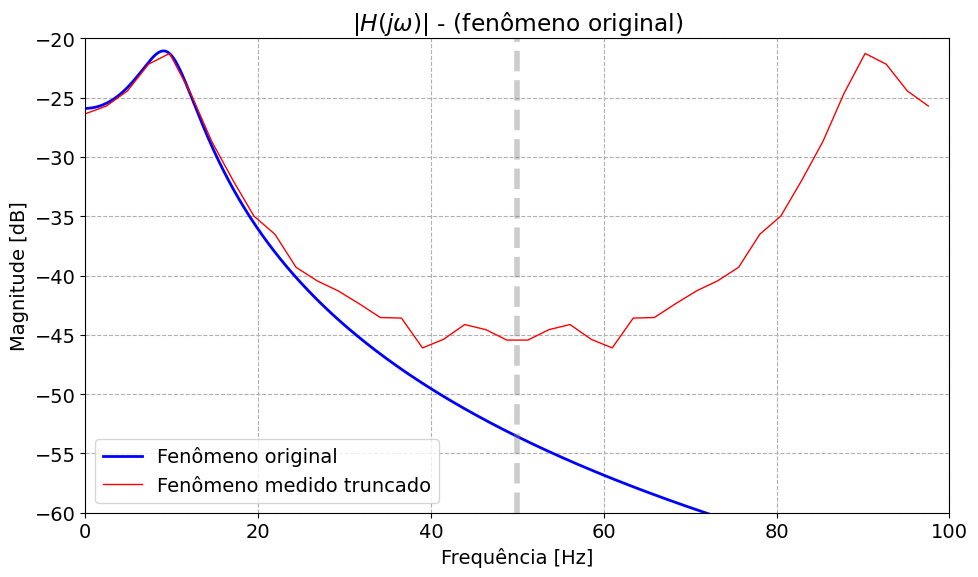

In [25]:
ht_med_trunc = ht_med[time<=0.4]

Nt = len(time[time<=0.4]) # Número de pontos da FFT
#Hw_med_trunc = np.fft.fft(ht_med_trunc) # Tente esta linha depois
Hw_med_trunc = np.fft.fft(ht_med, Nt)
freq_vec_t = np.linspace(0, (Nt-1)*Fs/Nt, Nt)
print("O número de pontos na DFT é {}".format(Nt))
print("Vetor de frequência: {:.2f}, {:.2f}, {:.2f}, ... {:.2f}".format(freq_vec_t[0], freq_vec_t[1],
    freq_vec_t[2], freq_vec_t[-1]))
print("Resolução do espectro: {:.2f} [Hz]".format(freq_vec_t[1]-freq_vec_t[0]))


plt.figure(figsize=(10,6))
plt.title(r'$|H(j\omega)|$ - (fenômeno original)')
plt.plot(freq, 20*np.log10(np.abs(Hw)), '-b', linewidth = 2, label = 'Fenômeno original')
plt.plot(freq_vec_t, 20*np.log10(np.abs(Hw_med_trunc)/Fs), '-r', linewidth = 1, label = 'Fenômeno medido truncado')
plt.legend(loc = 'lower left')
plt.axvline(Fs/2, color='grey',linestyle = '--', linewidth = 4, alpha = 0.4)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.xlim((0, Fs)) # Extenda até Fs se desejar
plt.ylim((-60, -20))
plt.tight_layout()
plt.show()

### 3. Sinal truncado e com zeros no final.

Agora vamos truncar $h(t)$ e adicionar zeros no final. Note que a resolução do espectro no caso anterior diminuiu (maior $\Delta f$).

"If n is larger, the input is padded with zeros."

Se n for maior que que o comprimento do sinal, o sinal será completado com zeros. É indiferente fazer:

a. Truncar o sinal no tempo:
- ht_med_trunc = ht_med[time<=0.4]
- Nt = len(time[time<=0.4]) 
- ht_med_zp = np.concatenate((ht_med_trunc, np.zeros(N-Nt)))
- Hw_med_zp = np.fft.fft(ht_med_zp) # Tente esta linha depois

b. Passar Nt como o segundo argumento da FFT
- Hw_med_zp = np.fft.fft(ht_med_trunc, N)

O número de pontos na DFT é 500
Vetor de frequência: 0.00, 0.20, 0.40, ... 99.80
Resolução do espectro: 0.20 [Hz]


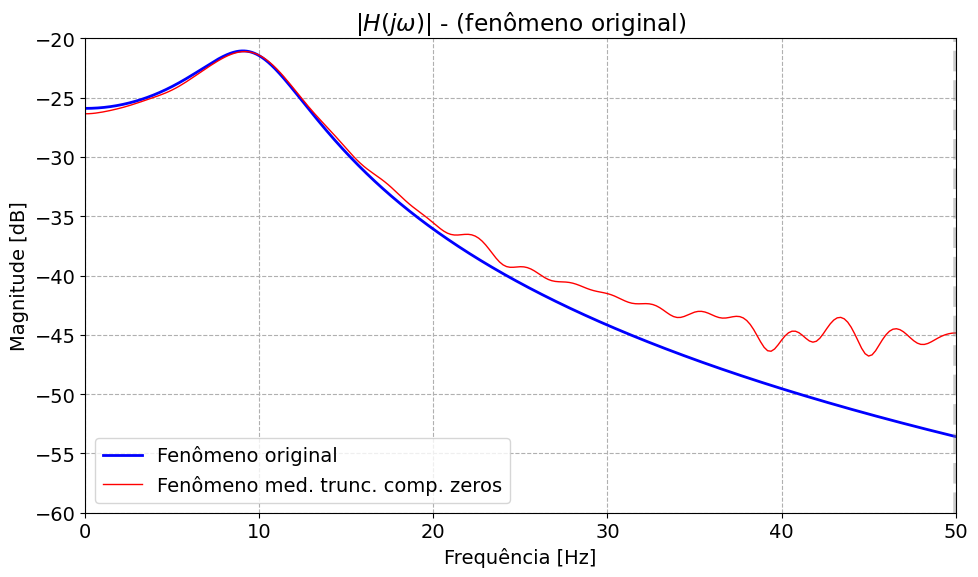

In [29]:
ht_med_trunc = ht_med[time<=0.4]
Nt = len(time[time<=0.4]) 

ht_med_zp = np.concatenate((ht_med_trunc, np.zeros(N-Nt)))

#N = 3*N
#Hw_med_zp = np.fft.fft(ht_med_zp) # Tente esta linha depois
Hw_med_zp = np.fft.fft(ht_med_trunc, N)

freq_vec_zp = np.linspace(0, (N-1)*Fs/N, N)
print("O número de pontos na DFT é {}".format(len(ht_med_zp)))
print("Vetor de frequência: {:.2f}, {:.2f}, {:.2f}, ... {:.2f}".format(freq_vec_zp[0], freq_vec_zp[1],
    freq_vec_zp[2], freq_vec_zp[-1]))
print("Resolução do espectro: {:.2f} [Hz]".format(freq_vec_zp[1]-freq_vec_zp[0]))


plt.figure(figsize=(10,6))
plt.title(r'$|H(j\omega)|$ - (fenômeno original)')
plt.plot(freq, 20*np.log10(np.abs(Hw)), '-b', linewidth = 2, label = 'Fenômeno original')
plt.plot(freq_vec_zp, 20*np.log10(np.abs(Hw_med_zp)/Fs), '-r', linewidth = 1, label = 'Fenômeno med. trunc. comp. zeros')
plt.legend(loc = 'lower left')
plt.axvline(Fs/2, color='grey',linestyle = '--', linewidth = 4, alpha = 0.4)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude [dB]')
plt.xlim((0, Fs/2)) # Extenda até Fs se desejar
plt.ylim((-60, -20))
plt.tight_layout()
plt.show()

In [22]:
Nt

41

## Trabalhando na IFFT

Vamos tratar rapidamente da transformada inversa e recuperar $h(t)$, a partir do espectro do sinal truncado e completado com zeros.

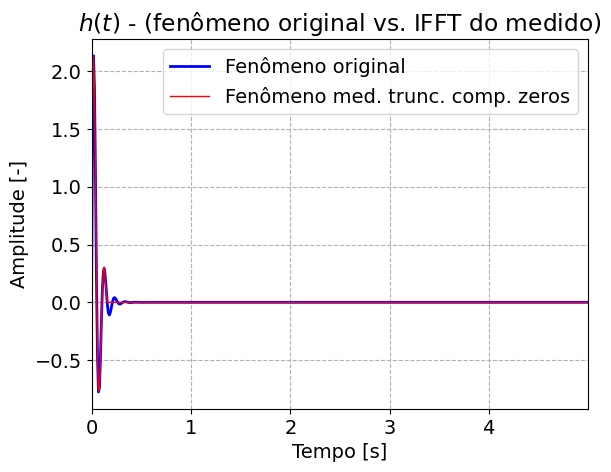

In [34]:
ht_rec = np.fft.ifft(Hw_med_zp) # ifft
N_rec = len(ht_rec) # Número de amostras
t_mrec = (N_rec-1)/Fs # tempo máximo da ifft
time_rec = np.linspace(0, t_mrec, N_rec) # vetor temporal recuperado da ifft

plt.figure()
plt.title(r'$h(t)$ - (fenômeno original vs. IFFT do medido)')
plt.plot(time, ht, '-b', linewidth = 2, label = 'Fenômeno original')
plt.plot(time_rec, np.real(ht_rec), '-r', linewidth = 1, label = 'Fenômeno med. trunc. comp. zeros')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((0, time[-1]));

### Inspecione ht_rec

Você vai notar que:

1. O sinal recuperado da IFFT tem uma pequena parte imaginária
2. Você precisa do espectro de $0$ a $F_s$ pra operar a IFFT corretamente.

In [20]:
ht_rec

array([-2.83544417e-03+7.77156117e-19j,  1.53302548e+00+2.73669976e-17j,
        2.12693370e+00-1.11022302e-17j,  1.83653399e+00+1.99840144e-17j,
        1.07173022e+00-1.35590424e-17j,  2.04370097e-01+4.13546360e-18j,
       -4.68083228e-01-4.32717266e-17j, -7.76520801e-01-7.27505434e-18j,
       -7.38266844e-01-7.72887825e-18j, -4.75473265e-01-5.19053210e-18j,
       -1.46709542e-01+3.48336022e-18j,  1.36161961e-01+3.73065872e-17j,
        2.65106431e-01-6.43574591e-18j,  2.95599177e-01-5.29506082e-18j,
        1.98111572e-01-2.11914175e-17j,  8.13792344e-02+3.66682951e-18j,
       -2.17856225e-02+1.90361714e-17j, -9.47408083e-02-5.05497863e-19j,
       -9.34413709e-02-1.42378261e-17j, -7.82205473e-02-9.05141118e-18j,
       -3.81648149e-02+1.15324501e-17j,  1.06092773e-02-3.14075536e-18j,
        5.70206844e-02-5.45074140e-18j,  4.45928061e-02-2.70493983e-17j,
        4.21439711e-02+1.72812229e-17j,  2.56299752e-02-2.63204203e-17j,
        1.84746309e-02-3.43277805e-17j, -1.44780226